## Forecasting quotations with ARIMA
### 1. Environment

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)

# numpy
import numpy as np
print('numpy: %s' % np.__version__)

# matplotlib
import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)

# seaborn
import seaborn as sns
print('seaborn: %s' % sns.__version__)

# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)

# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
print('statsmodels: %s' % statsmodels.__version__)

#pymongo
import pymongo
import pprint
print('pymongo: %s' % pymongo.__version__)

#json
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json

import itertools
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 1.13.3
seaborn: 0.8.0
pandas: 0.20.3
sklearn: 0.19.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


statsmodels: 0.8.0
pymongo: 3.4.0


### 2. Extracting Data

In [2]:
# Cria conexão com o Banco de Dados
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

# Cria Instância do Banco de Dados
db = client.AgroAnalyticsDatum

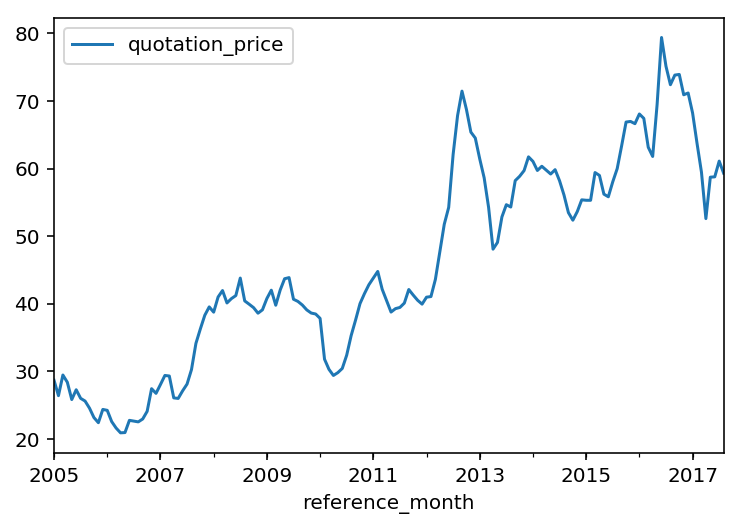

In [5]:
# Extrai dados Climáticos da Estação Selecionada
quotation = list(db.quotation_monthlies.find({'federal_unit_id': ObjectId('59867b535718ddc0b8efd9a0'),'product_id': ObjectId('59867b705718ddc1160a5ec0')}))
quotation_normalized = pd.io.json.json_normalize(quotation)
df_quotation = pd.DataFrame(quotation_normalized[['reference_month', 'quotation_price']])
df_quotation = df_quotation.set_index('reference_month')
ts_quotation = df_quotation['2000-01-01':'2017-08-01'].groupby(pd.TimeGrouper(freq='MS')).mean()
ts_quotation = ts_quotation.asfreq(freq='MS', method='bfill')
ts_quotation = ts_quotation[ts_quotation.index >= '2005-01-01']
ts_quotation.head()
ts_quotation.plot()

In [42]:
n_sample = ts_quotation.shape[0]

# Cria amostra de treinamento e de teste antes de realizar a análise
n_forecast=3
n_train=n_sample-n_forecast
#ts_df
ts_train = ts_quotation.iloc[:n_train]['quotation_price']
ts_test = ts_quotation.iloc[n_train:]['quotation_price']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(149,)
(3,)
Training Series: 
 reference_month
2017-01-01    68.2237
2017-02-01    63.7434
2017-03-01    59.4692
2017-04-01    52.5955
2017-05-01    58.7243
Freq: MS, Name: quotation_price, dtype: float64 

Testing Series: 
 reference_month
2017-06-01    58.7744
2017-07-01    61.1023
2017-08-01    59.3230
Freq: MS, Name: quotation_price, dtype: float64


### 3. Setting a Baseline with Naive Forecast

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation
history = [x for x in ts_train]
predictions = list()
for i in range(len(ts_test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = ts_test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(ts_test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=58.724, Expected= 59
>Predicted=58.774, Expected= 61
>Predicted=61.102, Expected= 59
RMSE: 1.692


### 4. Model Identification (ARIMA Model Determination)

In [44]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

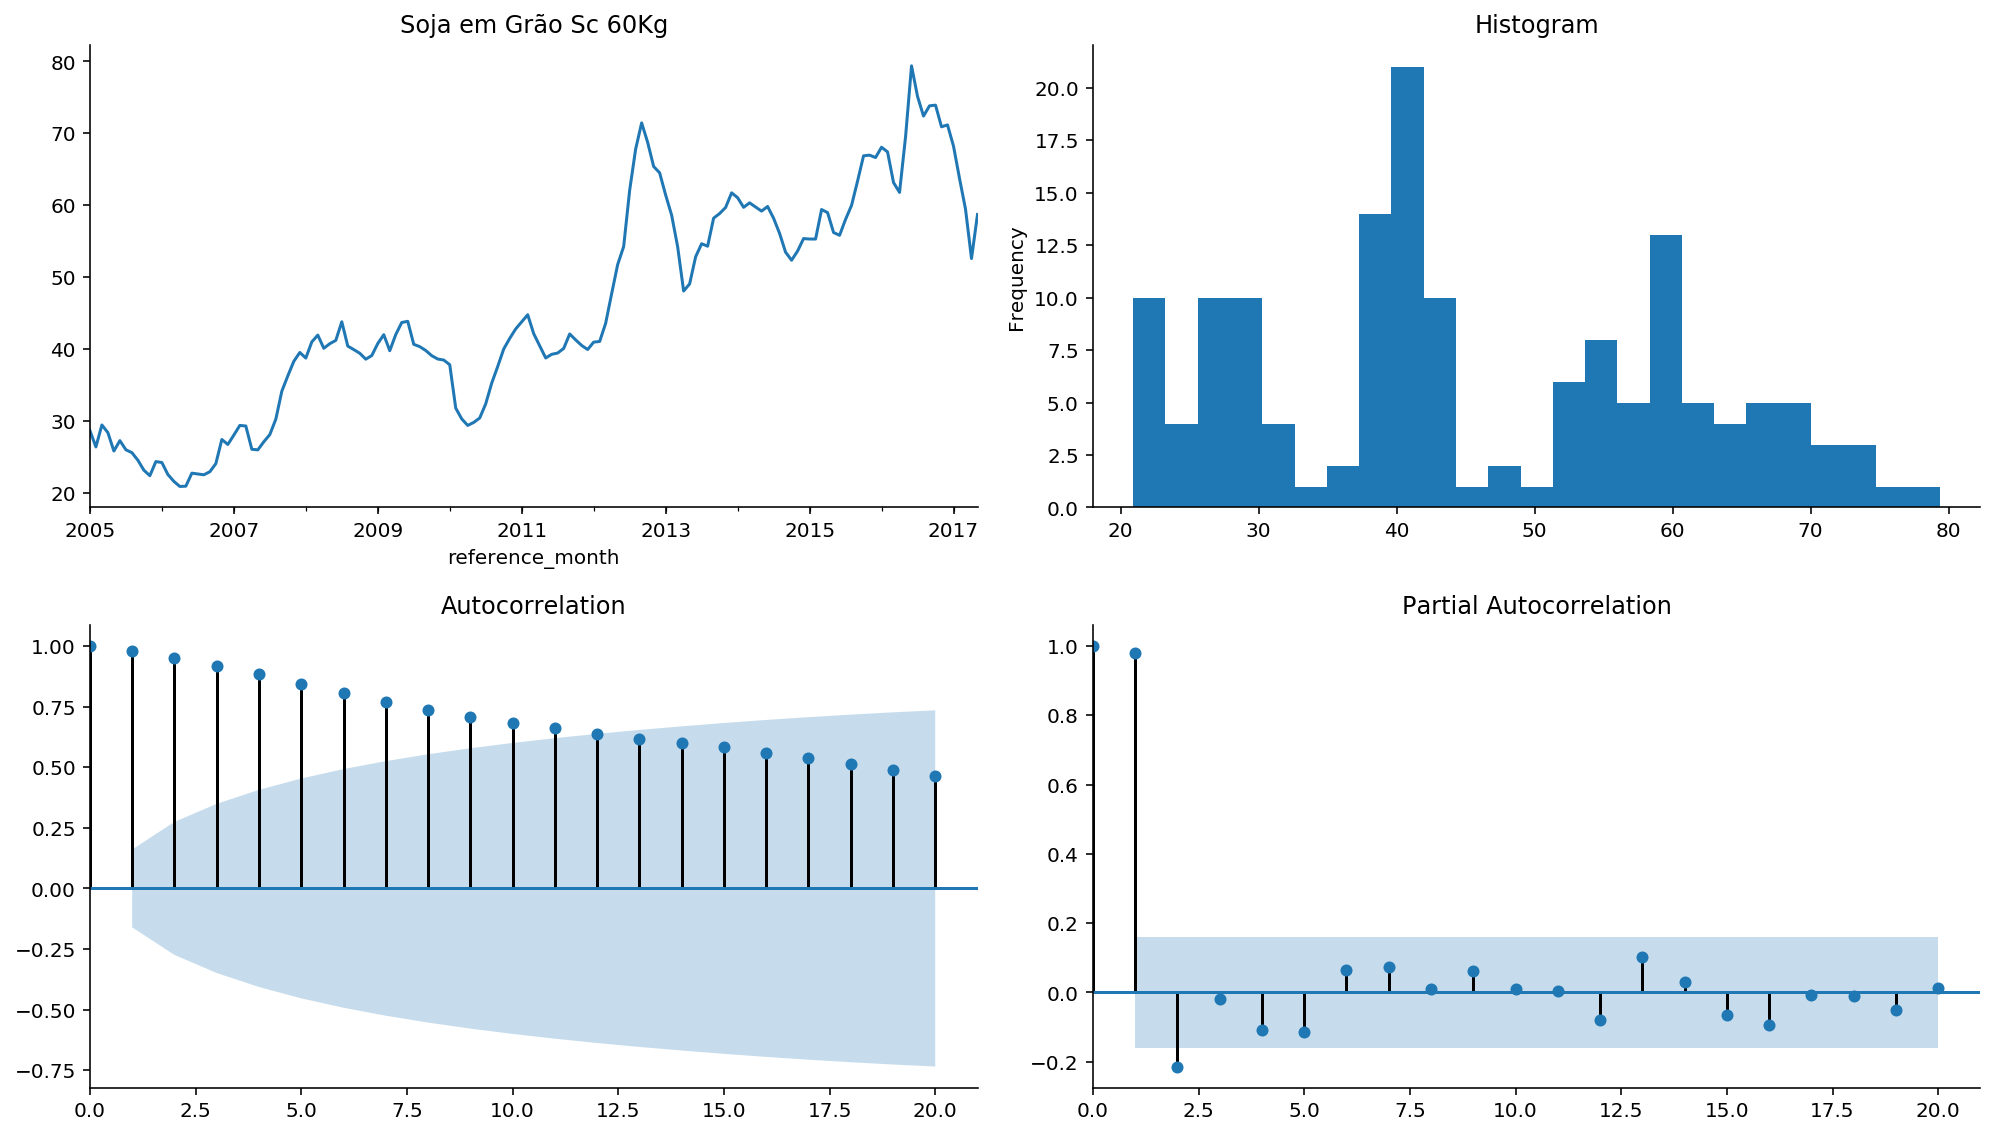

In [45]:
tsplot(ts_train, title='Soja em Grão Sc 60Kg', lags=20);

In [46]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    
    cols = ['EQM']
    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)
    
    
    
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                
                order = (p,d,q)
                
                # initialize to store results for this parameter set
                this_model = pd.DataFrame(index=[order], columns=cols)
                
                try:
                    mse = evaluate_arima_model(train, test, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    this_model['EQM']=mse
                    df_results = df_results.append(this_model)
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return df_results

# evaluate parameters
p_values = range(0,5)
d_values = range(1,2)
q_values = range(0,5)
warnings.filterwarnings("ignore")
df_results = evaluate_models(ts_train, ts_test, p_values, d_values, q_values)

Best ARIMA(0, 1, 0) MSE=1.686


In [47]:
df_results.sort_values(by='EQM').head(10)

,EQM
"(0, 1, 0)",1.685699
"(1, 1, 0)",2.389016
"(2, 1, 0)",3.194069
"(0, 1, 4)",3.332408
"(0, 1, 1)",3.571377
"(0, 1, 2)",3.578629
"(1, 1, 1)",3.580665
"(2, 1, 1)",3.627407
"(0, 1, 3)",3.645440
"(4, 1, 0)",3.793133


In [48]:
import itertools

p_min = 0
d_min = 1
q_min = 0
p_max = 5
d_max = 1
q_max = 5

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

results_aic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.ARIMA(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
        results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.aic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)
results_aic = results_aic[results_aic.columns].astype(float)

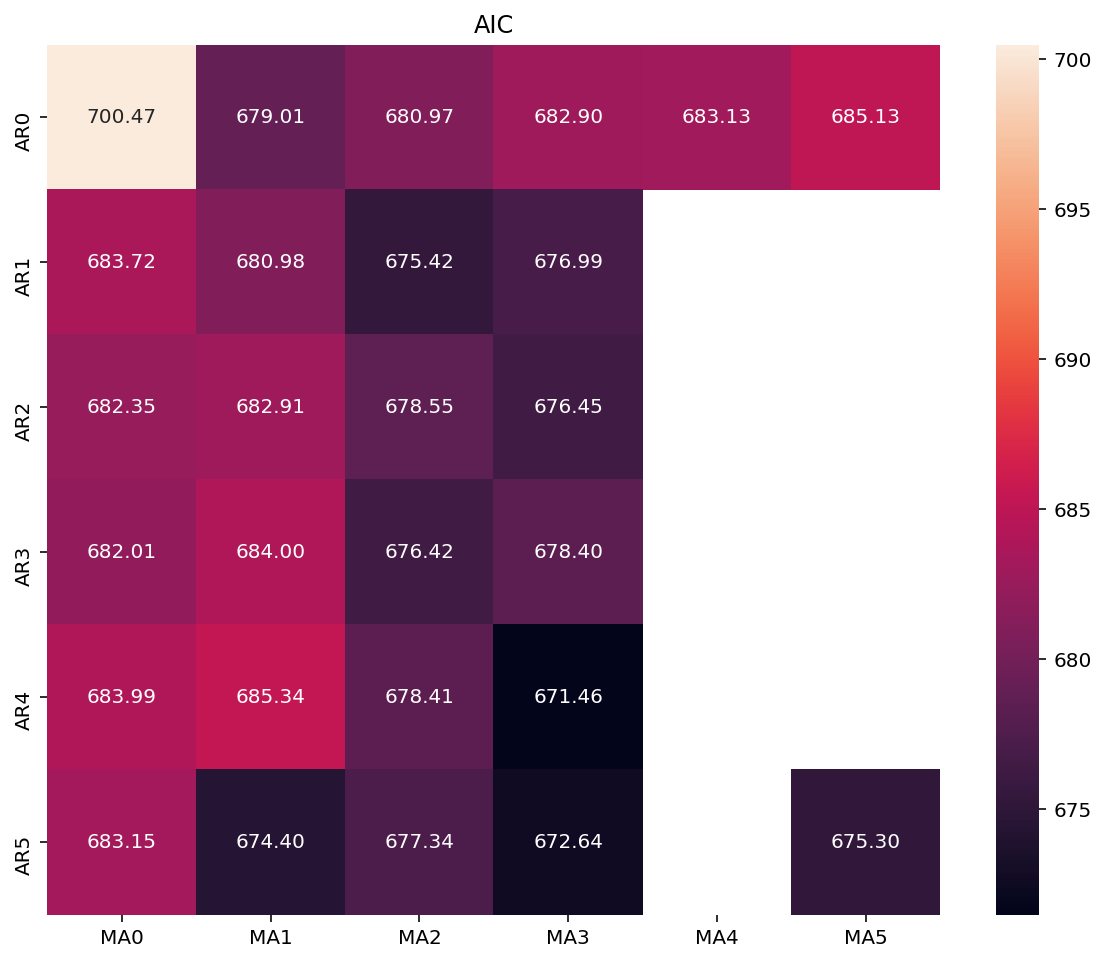

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_aic,
                 mask=results_aic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('AIC');

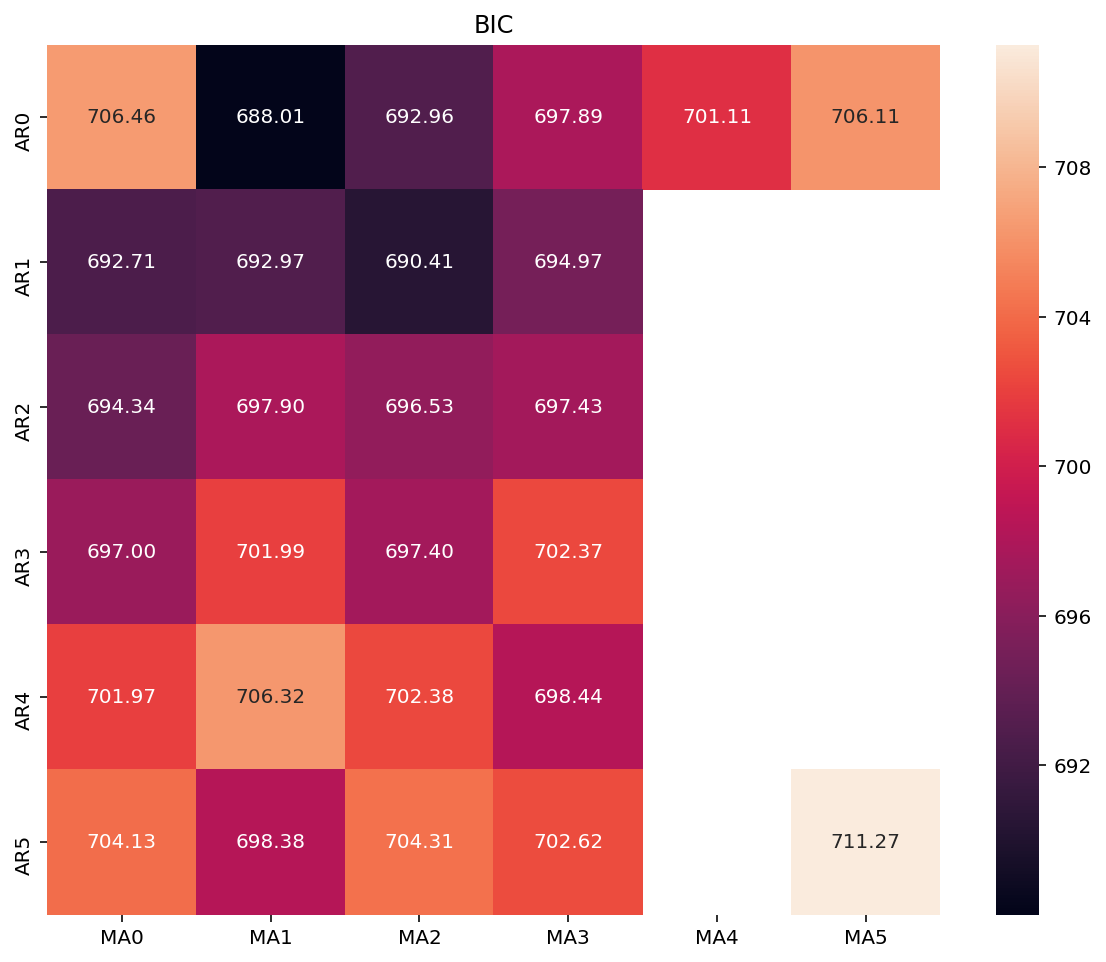

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [53]:
#Model Estimation

# Fit the model
arima012 = sm.tsa.SARIMAX(ts_train, order=(1,1,0))
model_results = arima012.fit()
print(model_results.summary())

                           Statespace Model Results                           
Dep. Variable:        quotation_price   No. Observations:                  149
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -339.113
Date:                Thu, 30 Nov 2017   AIC                            682.225
Time:                        08:51:31   BIC                            688.233
Sample:                    01-01-2005   HQIC                           684.666
                         - 05-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3553      0.046      7.720      0.000       0.265       0.446
sigma2         5.7191      0.479     11.929      0.000       4.779       6.659
Ljung-Box (Q):                       38.48   Jarque-

### 5. Model Diagnostic Checking

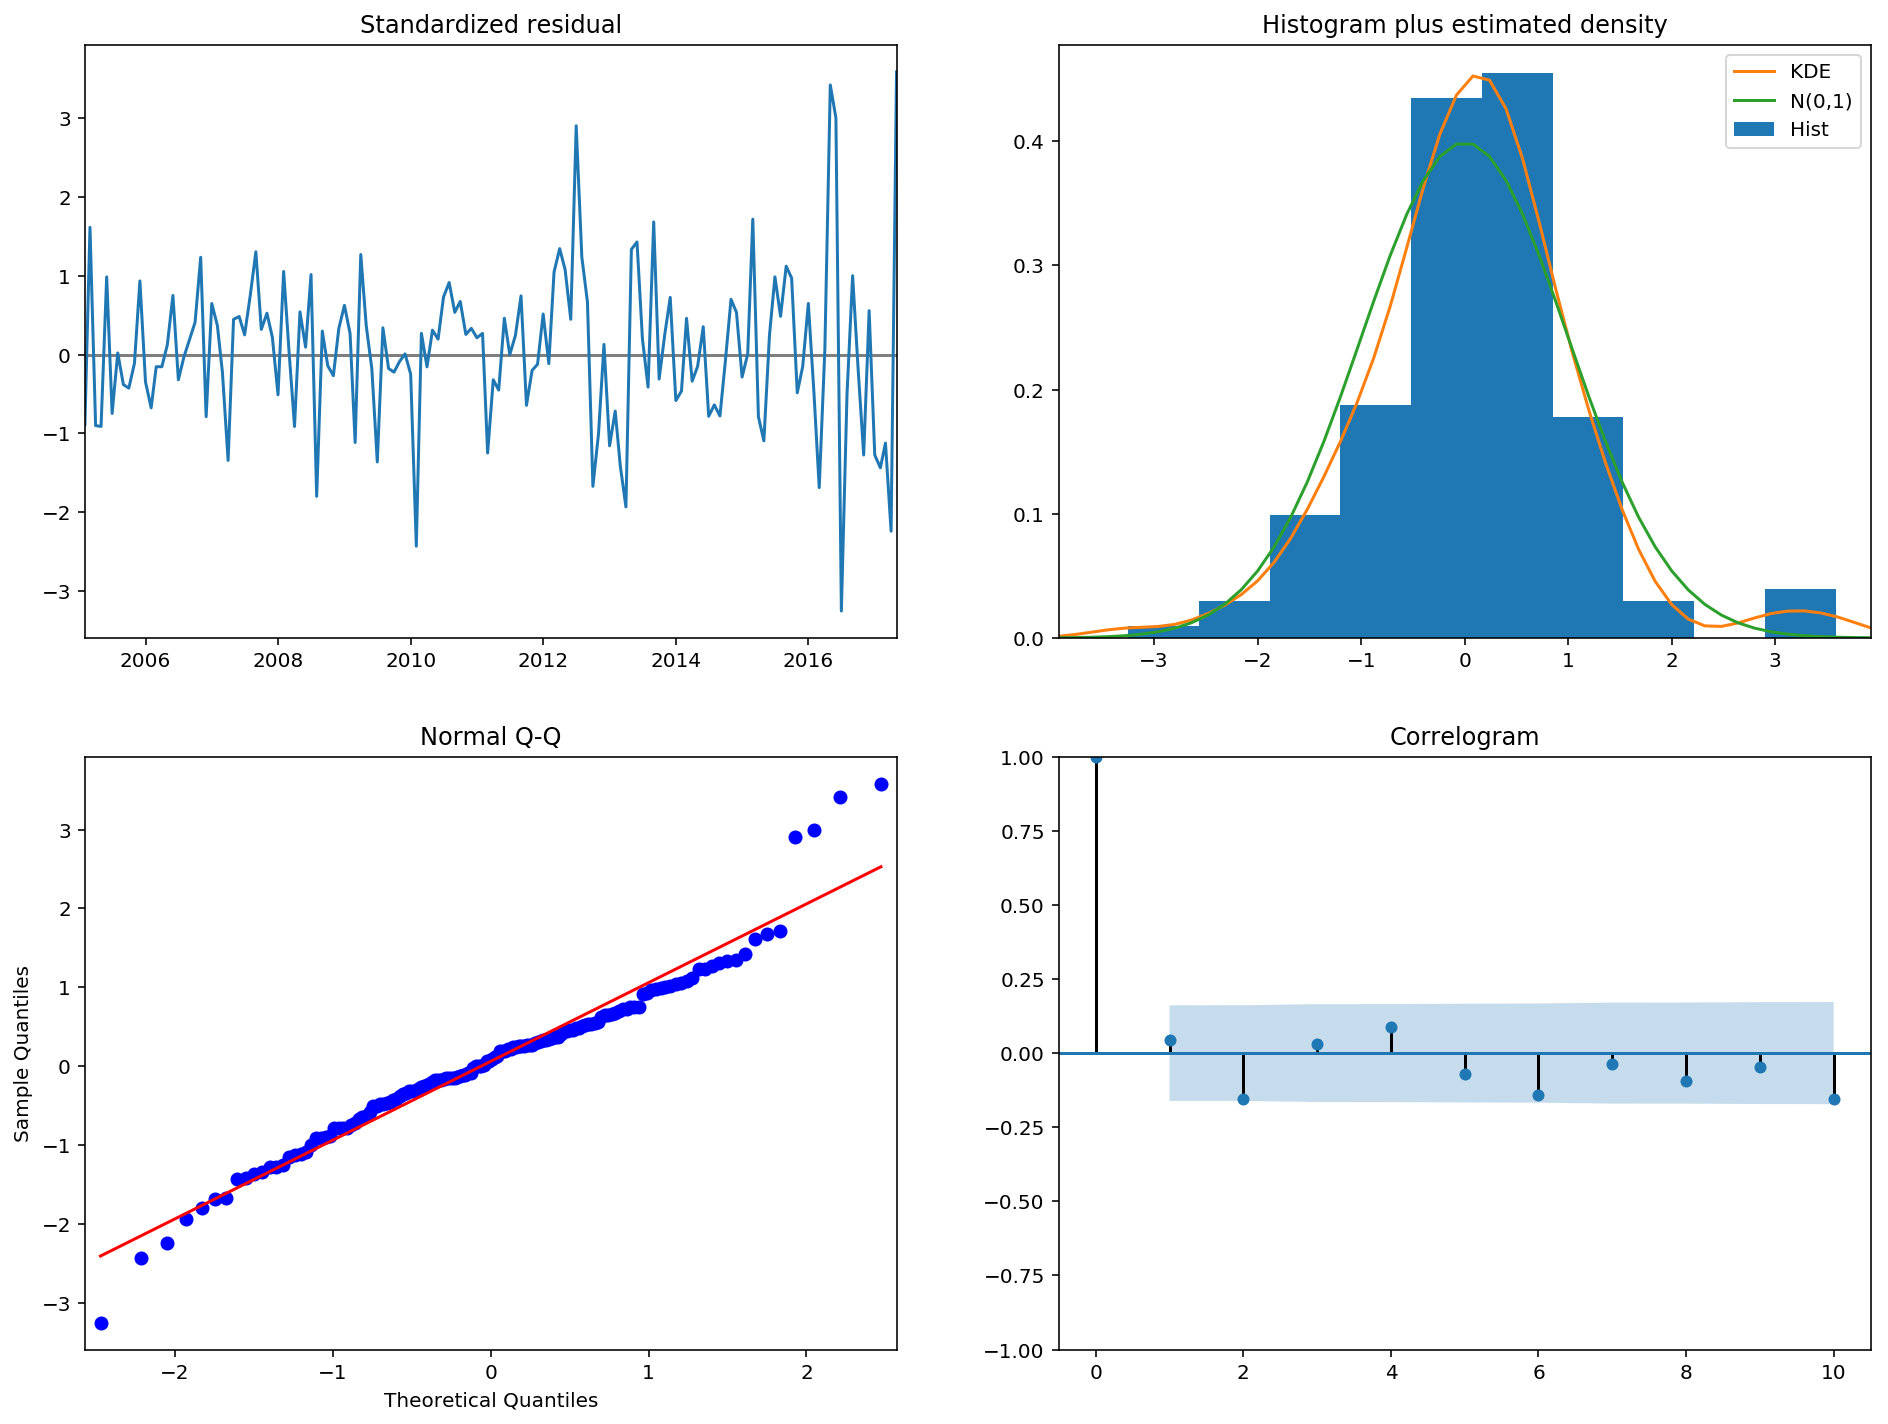

In [54]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals

model_results.plot_diagnostics(figsize=(16, 12));

In [55]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

Test heteroskedasticity of residuals (breakvar): stat=0.569, p=0.054

Test normality of residuals (jarquebera): stat=108.872, p=0.000

Test serial correlation of residuals (ljungbox): stat=49.888, p=0.136

Durbin-Watson test on residuals: d=2.04
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


### 6. Model performance evaluation (in-sample fit)

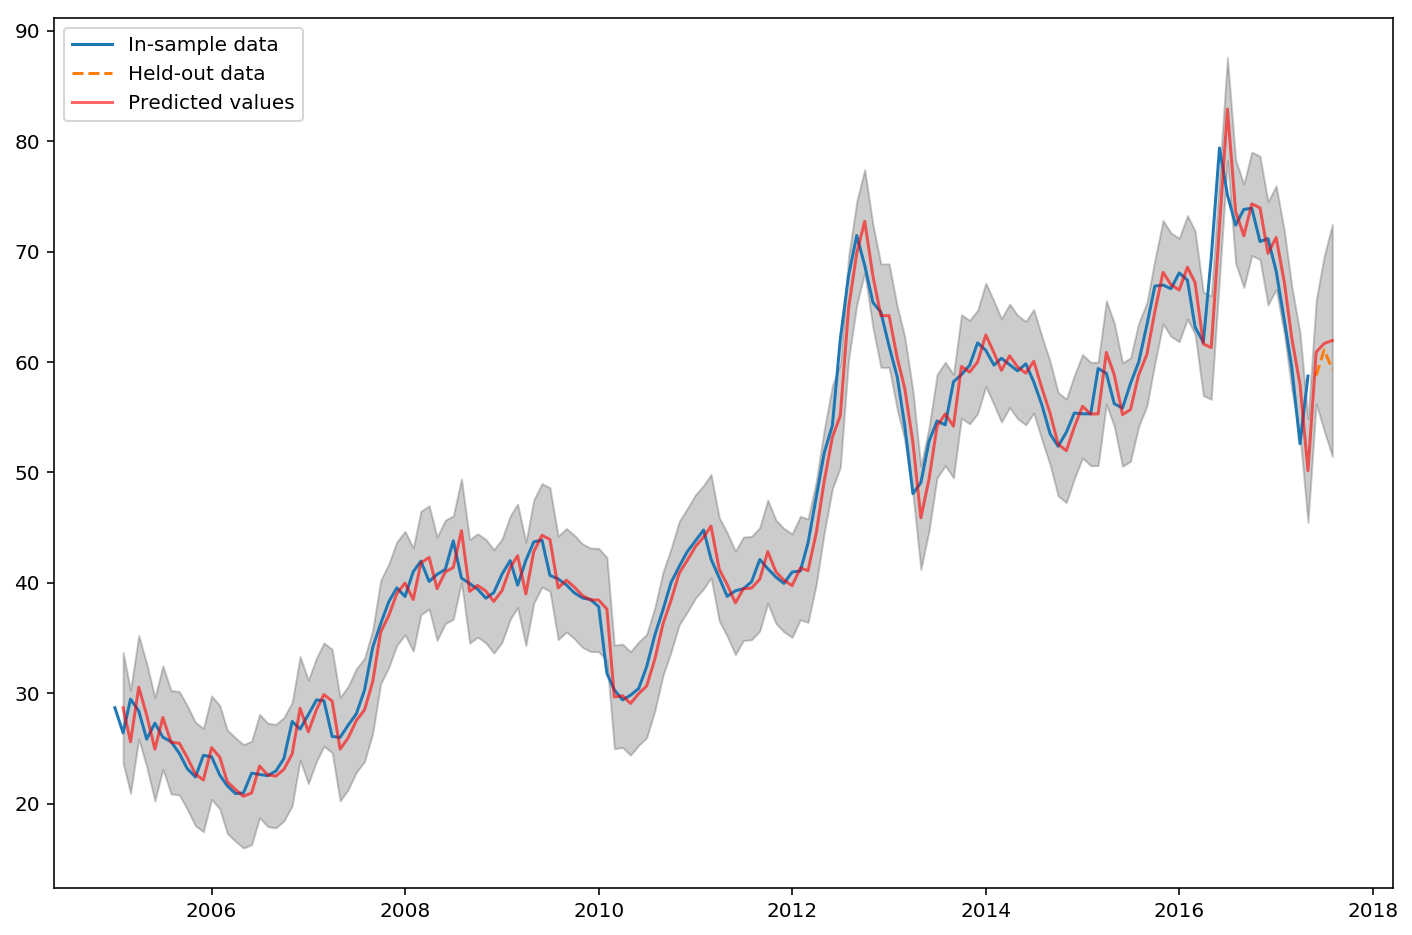

In [55]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

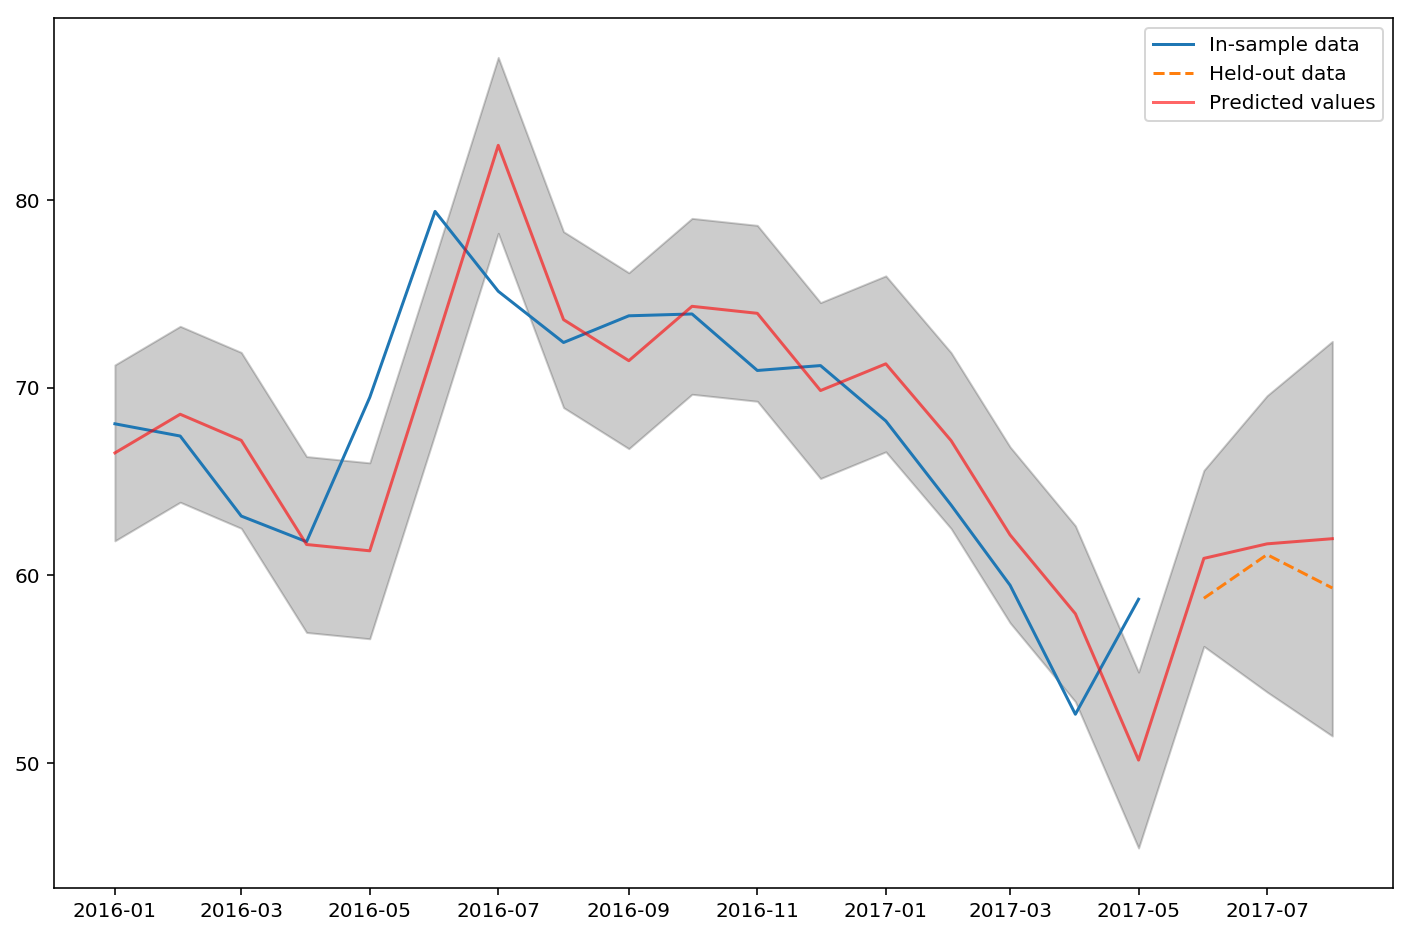

In [56]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train['2016-01-01':], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test['2016-01-01':], label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean['2016-01-01':], 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci['2016-01-01':].index,
                 pred_ci['2016-01-01':].iloc[:, 0],
                 pred_ci['2016-01-01':].iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [57]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [58]:
# Training Set

rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean.ix[ts_train.index])
print("MASE: ", mase)

RMSE:  2.39238904608
MAPE:  3.9466057152883236
MASE:  0.9999999999999997


In [59]:
# Test Set

rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print("RMSE: ", rmse)

mape = get_mape(ts_test, pred_mean.ix[ts_test.index])
print("MAPE: ", mape)

mase = get_mase(ts_test, pred_mean.ix[ts_test.index])
print("MASE: ", mase)

RMSE:  1.97980028811
MAPE:  2.9957483120703436
MASE:  1.1097798916496238
